In [ ]:
# Продолжайте развитие и анализ сгененированных данных.
# 4.1. На выбор, реализация текстурных характеристик:
#  - Признаки Тамура
#  - матрица взаимной встречаемости
# 4.2. На выбор, реализация алгоритма сегментации при помощи выбранного алгоритма кластеризации данных:
# https://scikit-learn.ru/stable/modules/clustering.html
# 4.2.1 Если в кодировке пикселя не использовали его положение, выделите связные регионы.
# 4.3. На выбор, рассчитайте Качество проведенной сегментации на основе характеристик качества кластеризации:
# https://scikit-learn.ru/stable/modules/clustering.html#clustering-evaluation
# 4.4. Визуализируйте результат сегментации
# 4.5 Рассчитайте характеристики(описание формы) объектов.
# 4.6 Используя алгоритм кластеризации, найдите количество классов объектов на изображении.

In [9]:
!pip install scikit-image

Tamura Features: {'contrast': np.float64(510.270386605784), 'homogeneity': np.float64(0.6372419189670527)}
Silhouette Score: 0.8400614


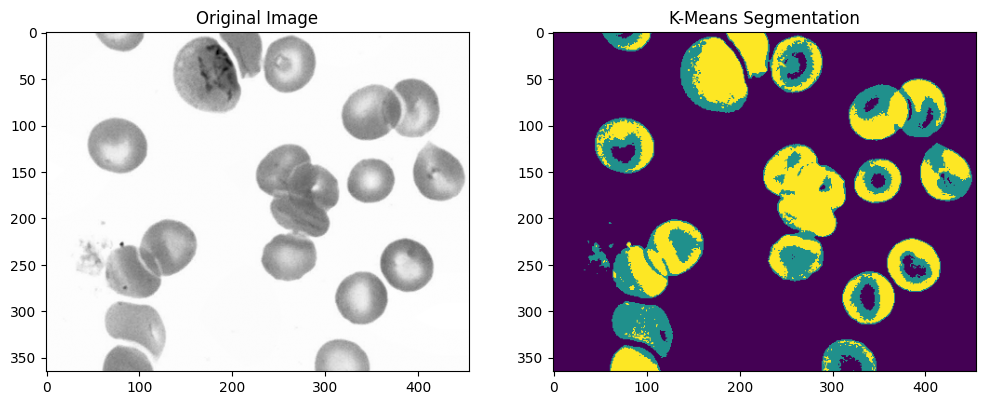

Number of connected components: 37


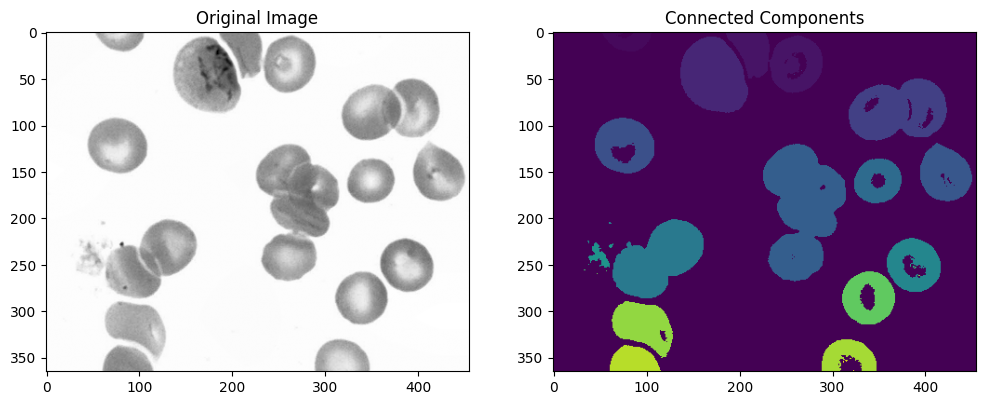

Shape Features: [{'area': np.float64(810.0), 'perimeter': np.float64(159.63961030678928), 'eccentricity': 0.9039688306746556, 'solidity': np.float64(0.8920704845814978), 'extent': np.float64(0.6946826758147513)}, {'area': np.float64(4029.0), 'perimeter': np.float64(503.9310242291876), 'eccentricity': 0.8489296820197726, 'solidity': np.float64(0.792486231313926), 'extent': np.float64(0.5782146957520092)}, {'area': np.float64(10.0), 'perimeter': np.float64(8.0), 'eccentricity': 1.0, 'solidity': np.float64(1.0), 'extent': np.float64(1.0)}, {'area': np.float64(4516.0), 'perimeter': np.float64(258.69343417595167), 'eccentricity': 0.6210148163801704, 'solidity': np.float64(0.9802474495333189), 'extent': np.float64(0.7544269963247577)}, {'area': np.float64(1.0), 'perimeter': np.float64(0.0), 'eccentricity': 0, 'solidity': np.float64(1.0), 'extent': np.float64(1.0)}, {'area': np.float64(1.0), 'perimeter': np.float64(0.0), 'eccentricity': 0, 'solidity': np.float64(1.0), 'extent': np.float64(1.0

In [18]:
import numpy as np
import cv2
from skimage.feature import graycomatrix, graycoprops
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score
from skimage import measure
from scipy import ndimage


def tamura_features(image):

    glcm = graycomatrix(image, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    return {'contrast': contrast, 'homogeneity': homogeneity}


def segment_image(image, n_clusters=3, use_position=False):
    height, width = image.shape
    pixels = image.reshape((-1, 1))
    pixels = np.float32(pixels)

    features = pixels

    if use_position:
        row, col = np.indices((height, width))
        row_flat = row.flatten()
        col_flat = col.flatten()
        position_features = np.stack((row_flat, col_flat), axis=-1)
        features = np.concatenate((pixels, position_features), axis=1)

    kmeans = KMeans(n_clusters=n_clusters, random_state=0,n_init="auto")
    labels = kmeans.fit_predict(features)
    segmented_image = labels.reshape((height, width))
    return segmented_image


def find_connected_components(segmented_image):

    labeled_image, num_labels = ndimage.label(segmented_image)
    return labeled_image, num_labels


def evaluate_segmentation(image, segmented_image):

    height, width = image.shape
    pixels = image.reshape((-1, 1))
    pixels = np.float32(pixels)
    labels = segmented_image.flatten()


    if len(np.unique(labels)) > 1:
        silhouette = silhouette_score(pixels, labels)
        return silhouette
    else:
        print("Warning: Only one cluster found. Silhouette score is not defined.")
        return -2


def visualize_segmentation(image, segmented_image, title="Segmentation Result"):

    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image, cmap='viridis')
    plt.title(title)

    plt.show()


def calculate_shape_features(labeled_image, num_labels):

    regions = measure.regionprops(labeled_image)
    features = []
    for region in regions:
        features.append({
            'area': region.area,
            'perimeter': region.perimeter,
            'eccentricity': region.eccentricity,
            'solidity': region.solidity,
            'extent': region.extent
        })
    return features


def cluster_objects(shape_features, bandwidth=None):

    if not shape_features:
        print("No shape features available for clustering.")
        return np.array([])


    data = np.array([list(feature.values()) for feature in shape_features])

    if bandwidth is None:
         bandwidth = estimate_bandwidth(data, quantile=0.2, n_samples=min(500, len(data)))

    if bandwidth == 0:
        print("Estimated bandwidth is 0. Cannot perform MeanShift clustering.")
        return np.zeros(len(data))

    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(data)
    labels = ms.labels_
    return labels

def main():

    image_path = '/content/fotk.PNG'
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return


    tamura = tamura_features(image)
    print("Tamura Features:", tamura)


    segmented_image = segment_image(image, n_clusters=3, use_position=False)


    silhouette = evaluate_segmentation(image, segmented_image)
    print("Silhouette Score:", silhouette)


    visualize_segmentation(image, segmented_image, "K-Means Segmentation")


    labeled_image, num_labels = find_connected_components(segmented_image)
    print("Number of connected components:", num_labels)
    visualize_segmentation(image, labeled_image, "Connected Components")


    shape_features = calculate_shape_features(labeled_image, num_labels)
    print("Shape Features:", shape_features)


    object_labels = cluster_objects(shape_features)

    if len(np.unique(object_labels)) > 0:
        num_object_classes = len(np.unique(object_labels))
        print("Number of object classes:", num_object_classes)
    else:
        print("No objects were clustered.")



if __name__ == "__main__":
    main()
